# 4　batch処理型のベイズ最適化

基本的なベイズ最適化のアルゴリズムでは、次の実験候補は基本1つのみを提示します。このようなベイズ最適化を、sequential処理型のベイズ最適化とよびます。しかし実験計画では、次の実験候補を複数提案してほしい場面があり、このような場面ではsequentialなベイズ最適化は適切ではありません。そこで今回は、複数の実験候補を提案するbatch処理型のベイズ最適化を紹介していきます。

batch処理型のベイズ最適化として有名なものに、以下の4つのアルゴリズムがあります。

1. Thompson sampling
2. local penalization
3. Kriging believer algorithm
4. constant liar heuristic

Kriging believer algorithmとconstant liar heuristicは`GPyOpt`に実装されていないため、今回はThompson samplingとlocal penalizationを中心に解説していきます。

**Remark**　以下の実験では、`scipy<=1.4.1`へダウングレードしないとエラーが起こることがあるので注意してください。

## 4.1　課題設定

**課題**　ある材質は、硬度と粘度の2つの値から劣化促進度が決まることが知られています。そこで、ある会社はなるべく劣化促進度の低い材質を作るための硬度と粘度を効率的に探索したいと考えています。なお、事前実験によって100個の（硬度、粘度）の組については、その劣化促進度をデータとして持っているものとします。以下では、この課題に対してベイズ最適化によるアプローチを検討します。

[1]　事前実験のデータを読み込み、関数モデルの学習に用いる訓練データとモデルを評価するためのテストデータに分けてください。

[2]　複数のbatch処理型のベイズ最適化アルゴリズムを試してみましょう。

[3]　得られた関数モデルの平均関数や事後分散、および獲得関数を可視化してみましょう。

[4]　得られた関数モデルの予測の良さを評価しましょう。

In [1]:
# import文
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split    # new
from sklearn.preprocessing import StandardScaler    # new

import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

from sklearn.metrics import r2_score    # new

## 4.2　事前実験

In [2]:
data = pd.read_csv("./data/pre_experiment.csv")
data.head(n = 5)

,x1,x2,y
0,-3.0,-2.0,162.900
1,-2.4,-2.0,69.868
2,-1.8,-2.0,53.852
3,-1.2,-2.0,52.801
4,-0.6,-2.0,50.383


In [3]:
# GPyOptにわたすために、入力Xと出力yをどちらも2次元配列で準備する。
# sklearnは出力が1次元なので、準備の仕方が異なることに注意。
X, Y = data[["x1", "x2"]].values, data[["y"]].values

## 4.3 前処理と諸設定

### 前処理

* 説明変数Xは、各変数のスケールが揃っていることが望ましい。（ガウス過程回帰モデルのカーネル、batch処理型のアルゴリズムによってはスケール依存なものがあるため。）
* 説明変数Yは、数値計算の安定化のために正規化したほうがよい。（正規化：標準化・min-max正規化など）

説明変数は、各変数のスケールがほぼ同じなので正規化していない。

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
X_train.shape, X_test.shape

((70, 2), (30, 2))

In [5]:
# 入力Xの正規化
ss_X = StandardScaler()
ss_X.fit(X_train)
X_train_ss, X_test_ss = ss_X.transform(X_train), ss_X.transform(X_test)

In [6]:
# 入力Yの正規化
ss_Y = StandardScaler()
ss_Y.fit(Y_train)
Y_train_ss, Y_test_ss = ss_Y.transform(Y_train), ss_Y.transform(Y_test)

### 諸設定

探索範囲を指定する。今回は、硬度(x1)は-3<x1<3で、粘度(x2)は-2<x2<2で探索する。

In [7]:
# 標準化された入力に対する探索範囲の計算
X_mm = np.array([[-3, -2], 
                 [-3, 2], 
                 [3, -2], 
                 [3, 2]])
X_mm_ss = ss_X.transform(X_mm)
X_mm_ss

array([[-1.60527141, -1.56897743],
       [-1.60527141,  1.90660548],
       [ 1.88444905, -1.56897743],
       [ 1.88444905,  1.90660548]])

In [8]:
# 最小値、最大値は標準化した値を設定する。
domain = [{"name" : "x1", "type" : "continuous", "domain" : (-1.47, 2.00)},
          {"name" : "x2", "type" : "continuous", "domain" : (-1.64, 1.95)}]    # boundsと名付ける人もいます。

In [9]:
# 別の書き方。
#domain = [{"name" : "x1", 
#           "type" : "continuous", 
#           "domain" : (X_mm_ss[:, 0].min(), X_mm_ss[:, 0].max())},
#          {"name" : "x2", 
#           "type" : "continuous", 
#           "domain" : (X_mm_ss[:, 1].min(), X_mm_ss[:, 1].max())}]    # boundsと名付ける人もいます。

In [10]:
kernel = GPy.kern.Matern52(input_dim = 2)

## 4.4　Thompson sampling

**Thompson sampling**は、主に獲得関数がEIのときのbatch処理型Bayes最適化アルゴリズムの一つです。$y^{*}$をこれまでの実験結果の最小値とするとき、EIの獲得関数は

$$
\begin{align*}
\alpha(x)=\mathbb{E}[(f(x)-y^{*})_{+}]
\end{align*}
$$

と表されます。sequential処理型Bayes最適化アルゴリズムでは、この獲得関数が最大値になる$x$（つまり1点のみ）を次の実験候補にしていました。一方でThompson samplingの場合は、関数の事後分布から関数を$B$個抽出し、これを$\hat{f}_{1}(x),\cdots,\hat{f}_{B}(x)$と表すとき、

$$
\begin{align*}
\alpha_b(x)=-(y^{*}-\hat{f}_{b}(x))_{+}
\end{align*}
$$

をEIの獲得関数のかわりに用います。また、それぞれの獲得関数の最大値を与える点$x_{1},\cdots,x_{B}$が、次の実験候補点として提案されます。

In [11]:
# ベイズ最適化の各種設定
opt = BayesianOptimization(f = None,    # remark1. 真の関数はわからないので指定しない。
                           domain = domain,
                           X = X_train_ss,    # remark2. 事前実験の入力の値
                           Y = Y_train_ss,    # remark2. 事前実験の出力の値
                           initial_design_numdata = 0,    # remark2. さらなる事前実験は行わない。
                           normalize_Y = False,    # remark3. あとで決定係数を計算するために正規化を施さない。
                           kernel = kernel,
                           aquisition_type = "EI",
                           evaluator_type = "thompson_sampling",    # remark4. トンプソン抽出を指定
                           batch_size = 3,    # remark5. 新しい実験候補を提案するべき数
                           exact_feval = False)    # remark6. 観測にはノイズが伴うと仮定

In [12]:
# 次の実験候補、ただし標準化された入力の値。
# 標準化前に戻す必要がある。
X_suggest = opt.suggest_next_locations()
X_suggest

array([[ 1.04979447, -0.52568702],
       [ 1.04978609, -0.52567814],
       [ 0.01809199,  1.04292761]])

In [13]:
# 次の実験候補、特に標準化前の実際の入力値。]
# こちらが本来知りたい値。
ss_X.inverse_transform(X_suggest)

array([[ 1.56494881, -0.79929159],
       [ 1.5649344 , -0.79928137],
       [-0.20889381,  1.00600516]])

In [14]:
# 候補に対する予測値と事後分散（活用か探索か）を計算する
opt.model.predict(X_suggest)

(array([[-0.7254555 ],
        [-0.72545542],
        [-0.70742795]]),
 array([[0.05253097],
        [0.05253104],
        [0.04222387]]))

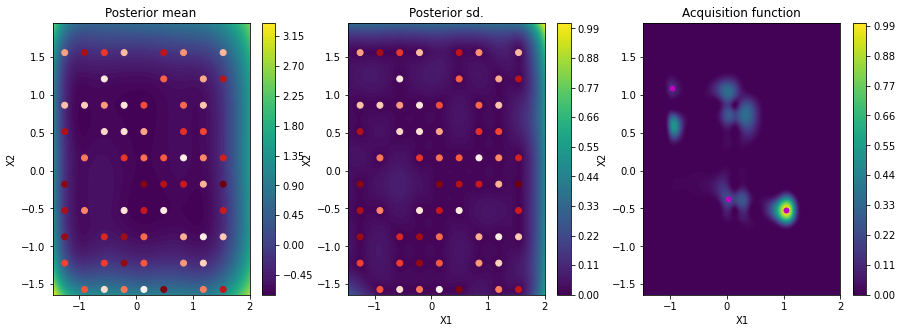

In [15]:
opt.plot_acquisition()

In [ ]:
# helpメソッド : 興味のあるメソッド（例えば`r2_score`）の使い方を確認する
# help(r2_score)

In [16]:
# 訓練データ上での決定係数
r2_score(y_true = Y_train_ss.reshape(-1), y_pred = opt.model.predict(X_train_ss)[0].reshape(-1))

0.999999999999986

In [17]:
# テストデータ上での決定係数
r2_score(y_true = Y_test_ss.reshape(-1), y_pred = opt.model.predict(X_test_ss)[0].reshape(-1))

0.996444403263767

## 4.5　local penalization

**local penalization**は、batch処理型Bayes最適化アルゴリズムの一つです。local penalizationのアイディアを一言でいうと、$b+1$個めの実験候補を提案するとき、$1,\cdots,b$個めに提案した実験候補の周辺は提案されづらくするという工夫です。"local penalization"という名前は、これを$1,\cdots,b$個めに提案した実験候補の周辺（local）で、獲得関数の値をpenalityの掛け算で小さくするというアイディアで実現したことからきています。

まず$1$個めの実験候補は、獲得関数$\alpha(x)$が最大のものが選択されます。つまり、sequential処理型のBayes最適化アルゴリズムと同様の結果になります。次に2個めの候補を選んでみましょう。ここでlocal penalizerとよばれる関数

$$
\begin{align*}
\phi(x;x_b) &= 1 - \mathbb{P}\left[\|x-x_b\|\leq\frac{f(x_b)-y^{*}}{\max_{n=1,\cdots,N}\|\nabla f(x_n)\|}\right]\\
&= 1 - \mathbb{P}\left[y^{*}+\max_{n=1,\cdots,N}\|\nabla f(x_n)\|\|x-x_b\|\leq f(x_b)\right]
\end{align*}
$$

を導入します。$y^{*}$はこれまでの実験結果の最小値です。なお、関数$f$が確率変数なので、この事後分布で確率を計算しています。この関数は、$x_b$から$x$が離れるほど値が大きくなることに注意してください。あとは、1個めに提案した実験候補を$x_1$と表すとき、

$$
\begin{align*}
\alpha(x)\phi(x;x_1)
\end{align*}
$$

が最大になるような値を2個めの実験候補として提案します。3個め以降も同様です。

In [18]:
opt = BayesianOptimization(f = None,    # remark1. 真の関数はわからないので指定しない。
                           domain = domain,
                           X = X_train_ss,    # remark2. 事前実験の入力の値
                           Y = Y_train_ss,    # remark2. 事前実験の出力の値
                           initial_design_numdata = 0,    # remark2. さらなる事前実験は行わない。
                           normalize_Y = False,    # remark3. あとで決定係数を計算するために正規化を施さない。
                           kernel = kernel,
                           aquisition_type = "EI",
                           evaluator_type = "local_penalization",    # remark4. local penalizationを指定
                           batch_size = 3,    # remark5. 新しい実験候補を提案するべき数
                           exact_feval = False)    # remark6. 観測にはノイズが伴うと仮定

In [19]:
X_suggest = opt.suggest_next_locations()    # 標準化後の実験候補の入力値
ss_X.inverse_transform(X_suggest)    # 標準化前の実験候補の入力値

array([[ 1.56499038, -0.7992539 ],
       [ 1.55053888, -0.74302935],
       [ 1.65495234, -0.73029483]])

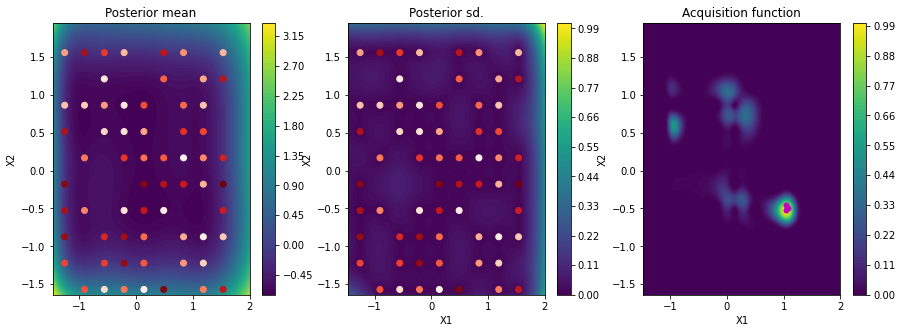

In [21]:
opt.plot_acquisition()

In [22]:
# 訓練データ上での決定係数
r2_score(y_true = Y_train_ss.reshape(-1), y_pred = opt.model.predict(X_train_ss)[0].reshape(-1))

0.999999999999986

In [23]:
# テストデータ上での決定係数
r2_score(y_true = Y_test_ss.reshape(-1), y_pred = opt.model.predict(X_test_ss)[0].reshape(-1))

0.996444402993814

## 4.6　Kriging beliver algorithmとconstant liar hueristic

**Kriging beliver algorithm**は、batch処理型のBayes最適化アルゴリズムのひとつです。このアルゴリズムでは、sequential処理型でBayes最適化アルゴリズムを行ったとき、$t$回目に提案した実験候補から$t+1$回目に提案する実験候補を予測すれば、batch処理型のBayes最適化アルゴリズムを作れるだろうという考え方を採用しています。

具体的な流れを説明します。まず1個めの実験候補には、獲得関数が最大になるような点$x_1$を選択します。次に2個めの実験候補を探していきます。

1. すでに得られているガウス過程回帰モデルのコピー$C$をとります。
2. ガウス過程回帰モデルの平均関数$\mu(x)$を用いてデータ$(x_1,\mu(x_1))$を作ります。
3. これを用いてガウス過程回帰モデルのコピー$C$を更新します。
4. 更新したコピー$C$を用いて獲得関数を計算し、最大値を与える点$x_2$を求めます。

この$x_2$を2個めの実験候補点とします。3個め以降も同様です。ここで、モデルのコピーをわざわざとったのは、一度実験候補を求めてデータをとったら、そのデータで更新したいのはコピー前のモデルのほうだからです。

一方で、モデルのコピー$C$を更新するとき、$(x_1,\mu(x_1))$の代わりに$(x_1,\min_{n=1,\cdots,N} y_{n})$を用いる方法を**constant liar heuristic**といいます。